In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [3]:
# Set parameters
estimatorType='rnn' # kalman or rnn
seeAction=True
seeMeasurement=True
seeEstimate=False
seeTime=False
T=12

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 8 samples, validate on 2 samples
Epoch 1/5
 - 5s - loss: 0.2847 - val_loss: 0.2759
Epoch 2/5
 - 0s - loss: 0.2388 - val_loss: 0.2199
Epoch 3/5
 - 0s - loss: 0.1911 - val_loss: 0.1648
Epoch 4/5
 - 0s - loss: 0.1422 - val_loss: 0.1254
Epoch 5/5
 - 0s - loss: 0.1086 - val_loss:

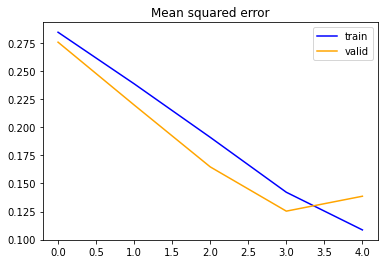

Done


In [4]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=10
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.3)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=5,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

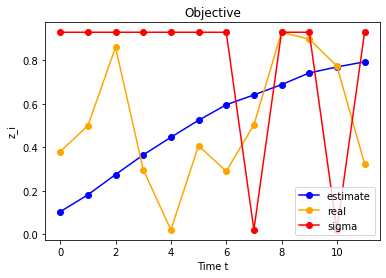

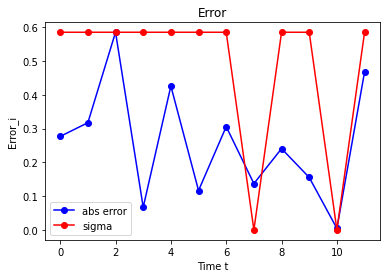

Done


In [5]:
if estimatorType=='rnn':
    idx_sample=0
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN[idx_sample:(idx_sample+1),:,:])
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()
print()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=500, windowSize=4)
rewarder.summarize()

RNN estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False

Threshold rewarder
  window size: 4
  threshold: 2
  cost: 500
  number of measures in the window: 0


In [7]:
# generate sequences for training the agent
numberSamples_trainAgent=500
T_trainAgent=T

(objectives_trainAgent,measurements_trainAgent)=estimator.generateSequence(T_trainAgent,numberSamples=numberSamples_trainAgent)

print('shape objectives:',np.shape(objectives_trainAgent))
print('shape measurements:',np.shape(measurements_trainAgent))

shape objectives: (500, 12, 1)
shape measurements: (500, 12, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_trainAgent,measurements_trainAgent)
print('Agent constructed')

Environment parameters
  inputDimensions= [(5,), (5, 1)]
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 500
  n_dim_obj= 1
  n_dim_meas= 1
RNN estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
Threshold rewarder
  window size: 4
  threshold: 2
  cost: 500
  number of measures in the window: 0
Agent constructed


In [9]:
# Train agent
agent.run(n_epochs=5, epoch_length=numberSamples_trainAgent*T_trainAgent)
print('Agent Trained')

/Users/antoine/Desktop/optiMeasRL-main/optimalIntermittency.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._last_ponctual_observation)


Average (on the epoch) training loss: 0.07159324735403061
Episode average V value: -0.12636692821979523
Average (on the epoch) training loss: 0.06938210129737854
Episode average V value: -0.13474496500566602
Average (on the epoch) training loss: 24.118608474731445
Episode average V value: -0.538662850856781
Average (on the epoch) training loss: 47.806617736816406
Episode average V value: -8.71976625919342
Average (on the epoch) training loss: 54.29150390625
Episode average V value: -15.962782859802246
Average (on the epoch) training loss: 52.93465805053711
Episode average V value: -15.040860956365412
Average (on the epoch) training loss: 49.555076599121094
Episode average V value: -10.428823471069336
Average (on the epoch) training loss: 46.75640106201172
Episode average V value: 0.008544430136680603
Average (on the epoch) training loss: 44.355037689208984
Episode average V value: -0.5798923373222351
Average (on the epoch) training loss: 42.18289566040039
Episode average V value: -6.13

Average (on the epoch) training loss: 18.636810302734375
Episode average V value: 0.9073052480816841
Average (on the epoch) training loss: 18.4805908203125
Episode average V value: 0.020656778166691463
Average (on the epoch) training loss: 18.434097290039062
Episode average V value: -0.47988489270210266
Average (on the epoch) training loss: 18.34551429748535
Episode average V value: 0.1155004786948363
Average (on the epoch) training loss: 18.29867172241211
Episode average V value: -0.3581620752811432
Average (on the epoch) training loss: 18.18232536315918
Episode average V value: -0.2282884567975998
Average (on the epoch) training loss: 18.0527400970459
Episode average V value: 0.9582276940345764
Average (on the epoch) training loss: 17.89739418029785
Episode average V value: 0.860036313533783
Average (on the epoch) training loss: 17.865459442138672
Episode average V value: -0.8298878806332747
Average (on the epoch) training loss: 17.73261070251465
Episode average V value: -0.126296684

Average (on the epoch) training loss: 12.92041301727295
Episode average V value: 0.24451838433742523
Average (on the epoch) training loss: 12.894347190856934
Episode average V value: -4.06859662045132
Average (on the epoch) training loss: 12.89163875579834
Episode average V value: -0.54786466807127
Average (on the epoch) training loss: 12.855584144592285
Episode average V value: 0.15889314065376917
Average (on the epoch) training loss: 12.876761436462402
Episode average V value: -0.836431880791982
Average (on the epoch) training loss: 12.86709213256836
Episode average V value: -0.44579899311065674
Average (on the epoch) training loss: 12.86242389678955
Episode average V value: 0.9882067367434502
Average (on the epoch) training loss: 12.809818267822266
Episode average V value: 0.252899169921875
Average (on the epoch) training loss: 12.778037071228027
Episode average V value: 1.1034796237945557
Average (on the epoch) training loss: 12.773234367370605
Episode average V value: 0.6295014619

Average (on the epoch) training loss: 10.333430290222168
Episode average V value: 1.1972566843032837
Average (on the epoch) training loss: 10.313546180725098
Episode average V value: 0.6263273940844969
Average (on the epoch) training loss: 10.288445472717285
Episode average V value: 0.8772648808856806
Average (on the epoch) training loss: 10.26315689086914
Episode average V value: 0.021935274824500084
Average (on the epoch) training loss: 10.238194465637207
Episode average V value: 0.40477904429038364
Average (on the epoch) training loss: 10.224244117736816
Episode average V value: 1.1181572452187538
Average (on the epoch) training loss: 10.199422836303711
Episode average V value: 0.6342854176958402
Average (on the epoch) training loss: 10.185637474060059
Episode average V value: -0.2792837669452031
Average (on the epoch) training loss: 10.158968925476074
Episode average V value: -0.5867798328399658
Average (on the epoch) training loss: 10.125919342041016
Episode average V value: 1.037

Average (on the epoch) training loss: 8.669294357299805
Episode average V value: 0.26116013662381604
Average (on the epoch) training loss: 8.656590461730957
Episode average V value: 0.7350666522979736
Average (on the epoch) training loss: 8.642522811889648
Episode average V value: 0.9353020116686821
Average (on the epoch) training loss: 8.621804237365723
Episode average V value: 0.642146202425162
Average (on the epoch) training loss: 8.610617637634277
Episode average V value: 0.3547189508875211
Average (on the epoch) training loss: 8.592227935791016
Episode average V value: 0.4554292981823285
Average (on the epoch) training loss: 8.57886791229248
Episode average V value: 1.095243215560913
Average (on the epoch) training loss: 8.565364837646484
Episode average V value: 0.024878010153770447
Average (on the epoch) training loss: 8.551606178283691
Episode average V value: 0.317429780960083
Average (on the epoch) training loss: 8.538956642150879
Episode average V value: 0.302747738858064
Av

Average (on the epoch) training loss: 7.626986980438232
Episode average V value: 0.20735915276137265
Average (on the epoch) training loss: 7.613274097442627
Episode average V value: 0.3442249298095703
Average (on the epoch) training loss: 7.604384899139404
Episode average V value: 0.24462399834936316
Average (on the epoch) training loss: 7.600221157073975
Episode average V value: 0.4606076776981354
Average (on the epoch) training loss: 7.591066837310791
Episode average V value: 0.29011593262354535
Average (on the epoch) training loss: 7.579351902008057
Episode average V value: 0.2500358323256175
Average (on the epoch) training loss: 7.565110683441162
Episode average V value: 0.3027980203429858
Average (on the epoch) training loss: 7.556249141693115
Episode average V value: 0.4601985303064187
Average (on the epoch) training loss: 7.550355434417725
Episode average V value: 0.3351767770946026
Average (on the epoch) training loss: 7.54166316986084
Episode average V value: 0.327925554730675

Average (on the epoch) training loss: 6.850533485412598
Episode average V value: 0.746745166182518
Average (on the epoch) training loss: 6.853451251983643
Episode average V value: -38.25029885210097
Average (on the epoch) training loss: 6.8462653160095215
Episode average V value: 0.08589615672826767
Average (on the epoch) training loss: 6.8393378257751465
Episode average V value: 0.30455403837064904
Average (on the epoch) training loss: 6.831165790557861
Episode average V value: 0.049415066838264465
Average (on the epoch) training loss: 6.821476459503174
Episode average V value: 0.05779660182694594
Average (on the epoch) training loss: 6.815670967102051
Episode average V value: 0.07366579229181464
Average (on the epoch) training loss: 6.805422306060791
Episode average V value: 0.10043349862098694
Average (on the epoch) training loss: 6.7940473556518555
Episode average V value: 0.06681368161331523
Average (on the epoch) training loss: 6.785177707672119
Episode average V value: 0.5555148

In [10]:
# generate test data
numberSamples_test=200
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


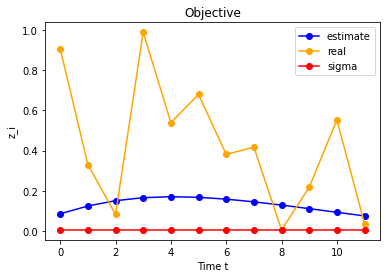

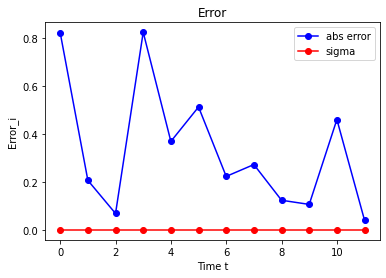

In [11]:
idx_sample=2
plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)

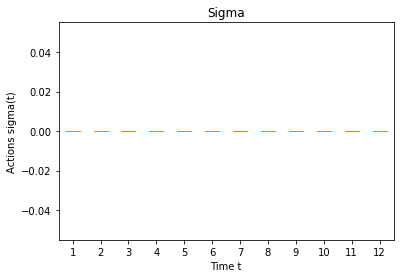

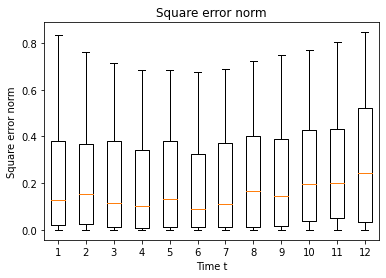

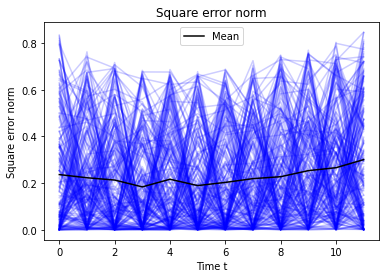

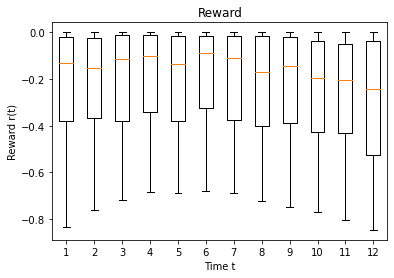

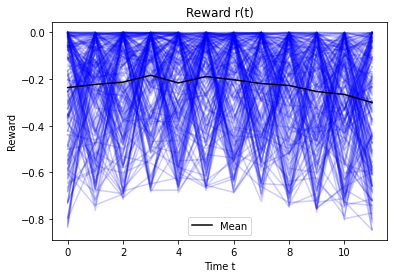

In [12]:
plotHistoSigmas(sigmas_test)
plotHistoErrors(objectives_test,estimates_test)
plotAllErrors(objectives_test,estimates_test)
plotHistoRewards(rewards_test)
plotAllRewards(rewards_test)